<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

In [3]:
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

In [4]:
import mltle as mlt

Done.


In [7]:
SEED = 7

NUM_RES_BLOCKS = 1
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 1024

data_path = '../data/data_pKd/'
data_type = 'pKd'
model_name = f'Res1CNN_{data_type}'

In [8]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.training.Model(drug_emb_size=128,
                          protein_emb_size=64,
                          max_drug_len=200,
                          drug_alphabet_len=53,
                          protein_alphabet_len=8006)

order = ['pKi', 'pIC50', 'pKd', 'pEC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(variables, discount=DISCOUNT, decay = 0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type: [tf.keras.metrics.mse, mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations[ 'qed']  = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                            activations=activations,
                            activation = 'relu',
                            pooling_mode = 'max',
                            num_res_blocks=NUM_RES_BLOCKS,
                            units_per_head=64,
                            units_per_layer=1024,
                            dropout_rate=0.3,
                            drug_kernel=(2, 3),
                            protein_kernel=(7, 7),
                            loss_weights=loss_weights,
                            usemetrics=usemetrics,
                            uselosses=uselosses,
                            initializer=initializer,
                            optimizer=optimizer,
                            drug_strides_up=1,
                            protein_strides_down=1,
                            positional=False)

2022-08-16 17:12:36.053312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 17:12:36.179454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 17:12:36.179624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 17:12:36.179754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Done. Total trainable params: 2391783


In [ ]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [10]:
X_train = pd.read_csv(data_path + f"data_human_agg05_{data_type}_train.csv")[['smiles', 'target'] + order]
X_valid = pd.read_csv(data_path + f"data_human_agg05_{data_type}_valid.csv")[['smiles', 'target'] + order]
X_test = pd.read_csv(data_path + f"data_human_agg05_{data_type}_test.csv")[['smiles', 'target'] + order]
X_train.head(2)

,smiles,target,pKi,pIC50,pKd,pEC50,is_active,qed,pH
0,CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...,MPHPRRYHSSERGSRGSYREHYRSRKHKRRRSRSWSSSSDRTRRRR...,NaN,NaN,5.744703,NaN,0.0,0.373344,NaN
1,NC(=NCC(F)(F)CC([NH3+])C(=O)[O-])NO,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...,NaN,NaN,3.935542,NaN,0.0,0.220408,NaN


In [11]:
mapseq = mlt.datamap.MapSeq(drug_mode='smiles_1',
                            protein_mode='protein_3',
                            max_drug_len=200,
                            max_protein_len=1000)

drug_seqs = np.hstack((X_train['smiles'].unique(), X_valid['smiles'].unique(), X_test['smiles'].unique()))
protein_seqs = np.hstack((X_train['target'].unique(), X_valid['target'].unique(), X_test['target'].unique()))

map_drug, map_protein = mapseq.create_maps(drug_seqs = drug_seqs, protein_seqs = protein_seqs)

  0%|          | 0/10362 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

In [12]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [13]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [14]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_{data_type}_mean_squared_error',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [15]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-08-16 17:12:40.952014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-16 17:12:41.799944: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-16 17:12:41.800252: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-16 17:12:41.800265: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-16 17:12:41.800494: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-16 17:12:41.800528: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-16 17:12:42.110253: I tensorflow/stream_executor/cuda/c


Epoch 1: val_pKd_mean_squared_error improved from inf to 43.22906, saving model to Best_Res1CNN_pKd.h5

Epoch 2: val_pKd_mean_squared_error improved from 43.22906 to 39.30144, saving model to Best_Res1CNN_pKd.h5

Epoch 3: val_pKd_mean_squared_error improved from 39.30144 to 35.86763, saving model to Best_Res1CNN_pKd.h5

Epoch 4: val_pKd_mean_squared_error improved from 35.86763 to 33.47279, saving model to Best_Res1CNN_pKd.h5

Epoch 5: val_pKd_mean_squared_error improved from 33.47279 to 32.50055, saving model to Best_Res1CNN_pKd.h5

Epoch 6: val_pKd_mean_squared_error did not improve from 32.50055

Epoch 7: val_pKd_mean_squared_error improved from 32.50055 to 32.17179, saving model to Best_Res1CNN_pKd.h5

Epoch 8: val_pKd_mean_squared_error did not improve from 32.17179

Epoch 9: val_pKd_mean_squared_error did not improve from 32.17179

Epoch 10: val_pKd_mean_squared_error improved from 32.17179 to 31.11844, saving model to Best_Res1CNN_pKd.h5

Epoch 11: val_pKd_mean_squared_error im


Epoch 105: val_pKd_mean_squared_error did not improve from 1.95001

Epoch 106: val_pKd_mean_squared_error did not improve from 1.95001

Epoch 107: val_pKd_mean_squared_error improved from 1.95001 to 1.93403, saving model to Best_Res1CNN_pKd.h5

Epoch 108: val_pKd_mean_squared_error improved from 1.93403 to 1.70988, saving model to Best_Res1CNN_pKd.h5

Epoch 109: val_pKd_mean_squared_error did not improve from 1.70988

Epoch 110: val_pKd_mean_squared_error improved from 1.70988 to 1.51743, saving model to Best_Res1CNN_pKd.h5

Epoch 111: val_pKd_mean_squared_error did not improve from 1.51743

Epoch 112: val_pKd_mean_squared_error improved from 1.51743 to 1.38458, saving model to Best_Res1CNN_pKd.h5

Epoch 113: val_pKd_mean_squared_error improved from 1.38458 to 1.36393, saving model to Best_Res1CNN_pKd.h5

Epoch 114: val_pKd_mean_squared_error did not improve from 1.36393

Epoch 115: val_pKd_mean_squared_error did not improve from 1.36393

Epoch 116: val_pKd_mean_squared_error did not 


Epoch 219: val_pKd_mean_squared_error did not improve from 1.05442

Epoch 220: val_pKd_mean_squared_error did not improve from 1.05442

Epoch 221: val_pKd_mean_squared_error did not improve from 1.05442

Epoch 222: val_pKd_mean_squared_error did not improve from 1.05442

Epoch 223: val_pKd_mean_squared_error did not improve from 1.05442

Epoch 224: val_pKd_mean_squared_error improved from 1.05442 to 1.04016, saving model to Best_Res1CNN_pKd.h5

Epoch 225: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 226: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 227: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 228: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 229: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 230: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 231: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 232: val_pKd_mean_squared_error did not improve from 1.04016

Epoch 


Epoch 338: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 339: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 340: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 341: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 342: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 343: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 344: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 345: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 346: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 347: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 348: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 349: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 350: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 351: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 352: val_pKd_mean_squared_error did not i


Epoch 459: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 460: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 461: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 462: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 463: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 464: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 465: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 466: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 467: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 468: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 469: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 470: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 471: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 472: val_pKd_mean_squared_error did not improve from 0.97507

Epoch 473: val_pKd_mean_squared_error did not i


Epoch 579: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 580: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 581: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 582: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 583: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 584: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 585: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 586: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 587: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 588: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 589: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 590: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 591: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 592: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 593: val_pKd_mean_squared_error did not i


Epoch 700: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 701: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 702: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 703: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 704: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 705: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 706: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 707: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 708: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 709: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 710: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 711: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 712: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 713: val_pKd_mean_squared_error did not improve from 0.94226

Epoch 714: val_pKd_mean_squared_error did not i


Epoch 820: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 821: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 822: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 823: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 824: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 825: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 826: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 827: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 828: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 829: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 830: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 831: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 832: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 833: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 834: val_pKd_mean_squared_error did not i


Epoch 941: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 942: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 943: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 944: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 945: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 946: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 947: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 948: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 949: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 950: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 951: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 952: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 953: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 954: val_pKd_mean_squared_error did not improve from 0.94172

Epoch 955: val_pKd_mean_squared_error did not i

In [16]:
[f"{k} : {float(v)}" for k, v in variables.items()]

['pKi : 0.0',
 'pIC50 : 0.0',
 'pKd : 0.0',
 'pEC50 : 0.0',
 'is_active : 0.0',
 'qed : 0.0',
 'pH : 0.0']

In [17]:
model.load_weights(best_model_path)
model.compile()
model.save(f"{model_name}.hdf5")

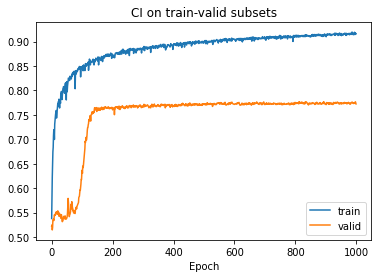

In [18]:
plt.plot(history.history[f'{data_type}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

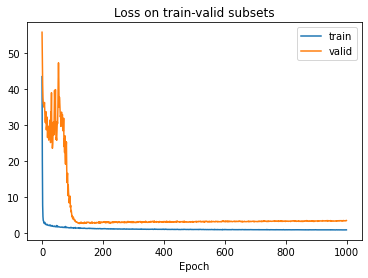

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [20]:
test_batch_size = mlt.training_utils.get_batch_size(X_test.shape[0])
test_batch_size

120

In [21]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True)

test_gen = test_gen.get_generator(test_batch_size)

In [22]:
prediction = model.predict(test_gen,
                           steps=X_test.shape[0] // test_batch_size,
                           verbose=1)

55/55 [==============================] - 1s 14ms/step


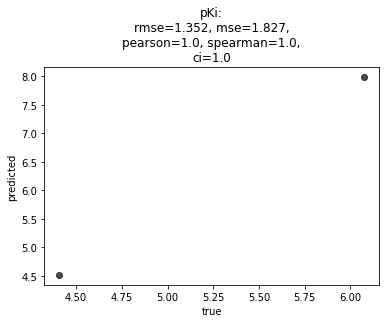

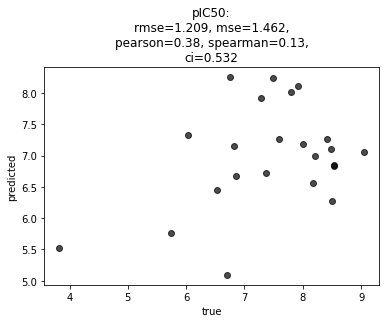

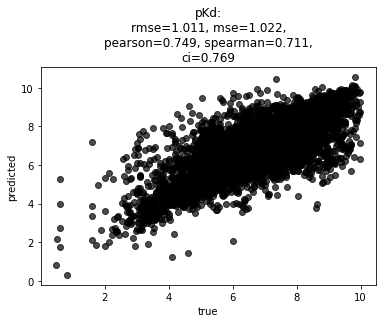

Empty set test set for: pEC50, values sum = 7.567030709125595
or zero concordand pairs for the set of length 1, length of values set = 1


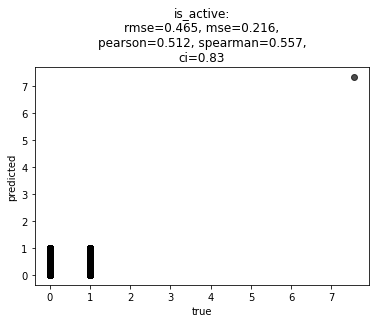

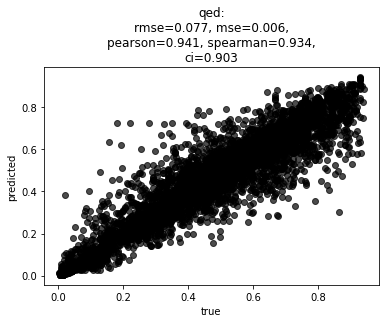

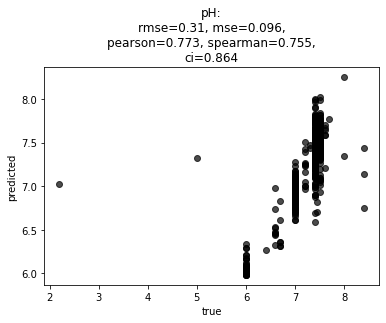

In [23]:
for k, col in enumerate(order):
    try:
        plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = X_test[col][X_test[col].notna()]
        y_pred = prediction[k][X_test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(f'Empty set test set for: {col}, values sum = {X_test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {X_test[col].notna().sum()}')

In [24]:
P = prediction[order.index(data_type)].ravel().tolist()
G = X_test[data_type].values.tolist()

In [25]:
with open(f'test_{data_type}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")

In [26]:
X_test.notna().sum()

smiles       6600
target       6600
pKi             2
pIC50          23
pKd          6600
pEC50           1
is_active    6600
qed          6600
pH            573
dtype: int64